In [5]:
###### HI HELLO
import numpy as np # fast array library
import pandas as pd # data frames library
from pandas_ods_reader import read_ods #read ods tables

import matplotlib 
import matplotlib.pyplot as plt # plot library
import matplotlib.gridspec as gridspec
import matplotlib.ticker as tck
from mycolorpy import colorlist as mcp # color levels from a color map

import subprocess # these 2 lines below load OS functionality
import sys
import json
import warnings
 
from IPython.display import display, HTML # screen on display in HTML library 

bimport sympy as sp # symbolic calculation library functions
from sympy import var # symbolic calculation library variables

import mpmath as mp # double (or higher) floating point precision library (not used)

import scipy.constants as ct # import mathematical constants
import scipy.special as spec
from scipy.spatial import Voronoi, voronoi_plot_2d # import Voronoi functions
import scipy.optimize as optimize # optimazation library (not used)
from scipy import signal # noise filtering functions
from scipy import stats # statistics, for binning and fields calculation
from scipy.fft import fft, ifft, fftfreq

from scipy.spatial import Voronoi, voronoi_plot_2d # import Voronoi functions


import ipywidgets as widgets # import 

import time # timing functions (for computation time)
from pytictoc import TicToc

# print progress function
# more elegant (python 3 alternative): print('\rhello', end='',flush=True)
def printp(string):
    sys.stdout.write('\r'+ str(string))
    sys.stdout.flush()
    
    
#from __future__ import print_function

# Text format for figures configuration (lines below)
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size': 20})
#rc('font',**{'family':'serif','serif':['Times']})
#rc('text', usetex=True)

In [6]:
%matplotlib ipympl

(-1.0, 1.0)

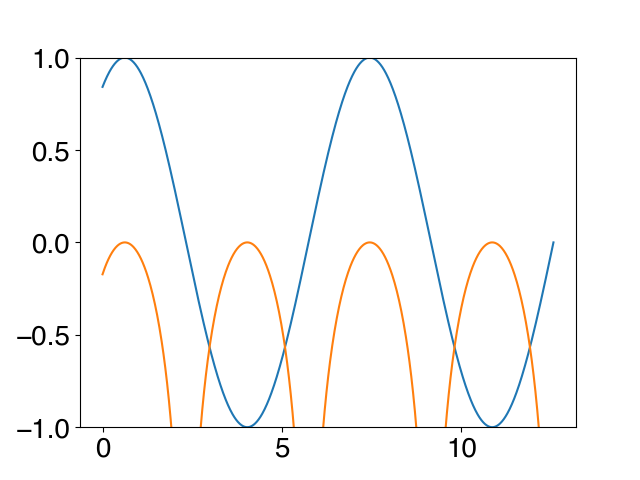

In [7]:
plt.figure(0)
plt.plot(np.linspace(0,4*np.pi,1000), np.sin(np.linspace(1,4*np.pi,1000)))
plt.plot(np.linspace(0,4*np.pi,1000), np.log(np.abs(np.sin(np.linspace(1,4*np.pi,1000)))) )
plt.ylim(-1,1)

In [8]:
plt.close(0)

## _Read tracking data_ 

We explain the action of each of these functions below:

__get_info(series_directory, hash_prefix, silent) :__ Reads and prints info file with  _hash prefix_ hash code. See output table in <font color='red' >RUN CELL 0</font> below to grasp the info structure

__simple_pickle_read(series_directory, hash_prefix) :__
This 'simple_pickle_read' takes a pkl.xz file _hash prefix_ hash code, and which contains xy positions and tracks (no velocities) and stores in 'tabla' pandas data frame.
   
  * input: hash_prefix
  * output: global variable _Ntracks_ (number of tracks) 

In [135]:
def pdisplay(info):
    display(HTML(info.T.to_html()))

# This function reads pickle binary file (.pkl) with trajectories
def get_info(series_directory, hash_prefix, silent):
    global info
    nombre = '/home/fvega/Datos/blades/packing_fraction_0' + series_directory + '/info/'  + hash_prefix + '.txt'
    with open(nombre) as f:
        jsonstr = json.load(f)
    info = pd.json_normalize(jsonstr)
    if silent==False:
        pdisplay(info.T)
    return info
    
def simple_pickle_read(series_directory, hash_prefix):
    global Nframes, Ntracks
    # Read table in pickle format
    nombre = '/home/fvega/Datos/blades/packing_fraction_0' + series_directory + '/ref_angle/' +  hash_prefix \
       + '.pkl.xz'
    tabla = pd.read_pickle(nombre, compression='infer')
    tabla = tabla.reset_index(drop=True) # por si los indices salen desordenados
    Nframes = np.max(tabla.frame)
    Ntracks = np.max(tabla.track)+1
    tabla = tabla.sort_values(by = ['frame', 'track']).reset_index(drop=True)
    print('\ndata table first rows: \n')
    pdisplay(tabla.head())
    return tabla

def get_ID( Npart, T_Temp, fps_value, experiments_list):
    experiments = read_ods(str(experiments_list), sheet=0)
    experiments = experiments[['ID', 'N', 'fps','Tt', 'w']][:115]
    selected_exp = experiments[experiments.N==Npart]
    selected_exp = selected_exp[selected_exp.fps==fps_value]
    T_Temp_list = np.abs(experimentos.Tt.values - T_Temp)
    closest_exp = np.where(T_Temp_list == np.min(T_Temp_list))[0][0]
    selected_ID = selected_exp.ID.values[closest_exp]
    print('experiment ID is: ', selected_ID)
    print('\nExact Tt is: ', selected_exp.Tt.values[closest_exp])
    return selected_ID

def get_data(Npart, T_Temp, fps_value, experiments_list):
    ID = get_ID(N, Tt, fps, experiments_list)
    print('\n[run "pdispay(info)" to print complete information on the selected experiment]\n')
    if Npart<10:
        prefix = '0'
    else:
        prefix=''
    return get_info(prefix + str(N), ID, True), simple_pickle_read( prefix + str(N), ID + '_w')

In [136]:
N = 45 # pick experiments series with N particles
Tt = 0.45 # approximate value of Tt you want to read
fps = 900 # chosen experiment movie fps rate (possible values: here, needs to be 900 always)
experiments_list = '/home/fvega/Datos/blades/tabla_experimentos.ods' # path to the experiment list table

info, tabla = get_data(N, Tt, fps, experiments_list)


experiment ID is:  712d5be2fce52eade6c5564a1f80368f

Exact Tt is:  2.646642

[run "pdispay(info)" to print complete information on the selected experiment]


data table first rows: 



,0,1,2,3,4
frame,1.000000,1.000000,1.000000,1.000000,1.000000
track,0.000000,1.000000,2.000000,3.000000,4.000000
x,40.447408,250.116228,148.381647,-101.934270,-22.228572
y,-328.000325,46.946393,46.766712,61.259356,72.072925
r,330.503922,254.483786,155.597506,118.969281,75.432304
vx,0.524411,0.081716,-0.524196,0.188688,-0.097197
vy,-0.130805,0.258624,-0.366213,0.546385,-0.233317
theta,0.054788,0.124128,0.028424,0.843234,0.078081
w,-0.257425,-0.306061,-0.259548,-0.256986,-0.228640


In [137]:
pdisplay(info)

,0
experiment_id,712d5be2fce52eade6c5564a1f80368f
original_file,/mnt/beegfs/malopez/serieAspas/serieAspas_N45_p23_fps900_1.cine
date,2038-01-19 06:37:38
shape,"[1280, 800]"
fps,900
exposure,1109
n_frames,24981
recording_time,27.756667
camera_distance,0.95
pixel_ratio,1075.862069


In [133]:
def time_shift_mat_av(array, it):
    nt = len(array)
    return np.sum( np.diag(array , k=it)[:nt,:nt].dot(array) )/(nt-i-1)

def time_shift_np_av(array, denom,it):
    return np.mean(array[:-it] * array[it:])/denom

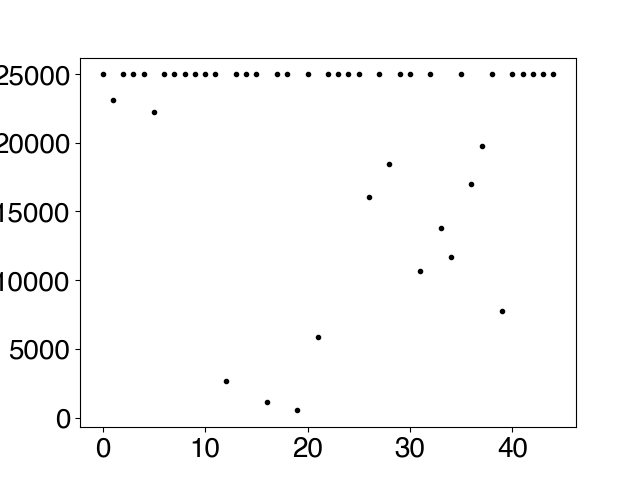

In [130]:
lengths = np.array([ len(tabla[tabla.track==i]) for i in range(info.N[0])])
nt = np.max(lengths)
parts=np.where( lengths>=nt)[0]

plt.figure(1)
plt.plot(lengths, '.', c='k')


In [131]:
plt.close(1)

In [134]:
lengths = np.array([ len(tabla[tabla.track==i]) for i in range(info.N[0])])

#nt = np.max(lengths)
nt = 20000
parts = np.where(lengths >= nt)[0]
nparts = len(parts)

t = np.array( [ i/info.fps[0] for i in range(nt) ] )
Awpt = np.zeros((nparts,nt))
Avpt = np.zeros((nparts,nt))

W0 = np.mean( tabla.w[tabla.frame<=nt] )
AW0 = np.mean( (tabla.w[tabla.frame<=nt] - W0)**2 )
Av0 = np.mean( tabla.vx[tabla.frame<=nt]**2 +  tabla.vy[tabla.frame<=nt]**2 )  

for j in range(nparts):
    w = tabla[tabla.track==parts[j]].w.values[:nt]
    W = w - np.mean(w)
    vx = tabla[tabla.track==parts[j]].vx.values[:nt]
    vy = tabla[tabla.track==parts[j]].vx.values[:nt]
    for i in range(1, nt-1):
        Awpt[j,i] = time_shift_np_av(W, 1, i)
        Avpt[j,i] = time_shift_np_av(vx, 1, i)
        if i%1000==0:
            printp(str(i) + ' for particle ' + str(j+1) + ' out of ' + str(nparts) + ' particles' )

Awt = np.mean(Awpt, axis=0)/AW0
Avt = np.mean(Avpt, axis=0)/Av0

spin_unit = 14/info.fps[0]
W0 = W0 / spin_unit # pasar de no. de aspas/frame a Hz (son 14 aspas)
printp("spin promedio (Hz): " + str(W0) + "     ")

spin promedio (Hz): -14.764124495275263     

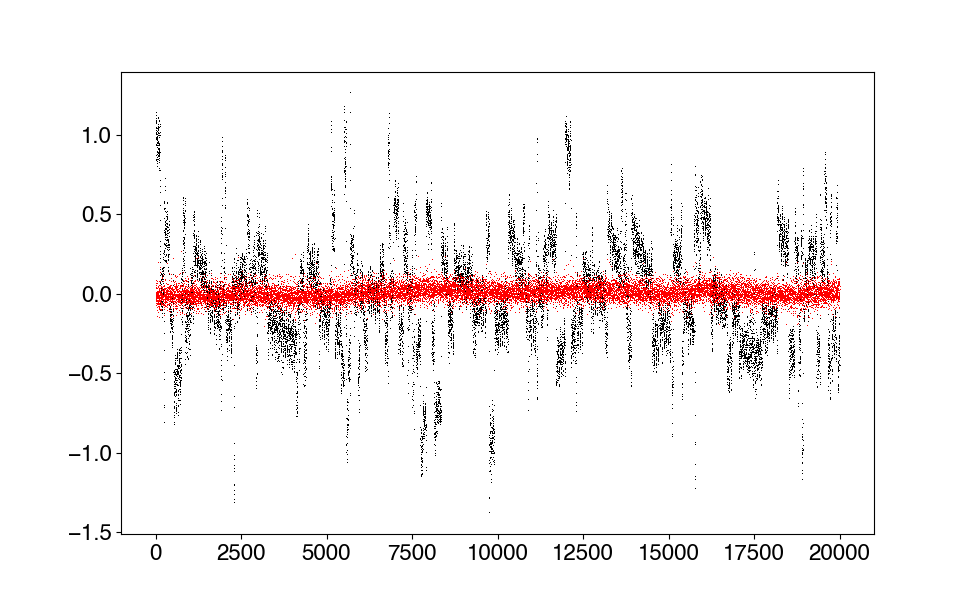

In [67]:
plt.figure(2, figsize=(6*ct.golden_ratio,6))
plt.plot(vx,',',c='k')
plt.plot(W,',', c='r')

In [66]:
plt.close(2)

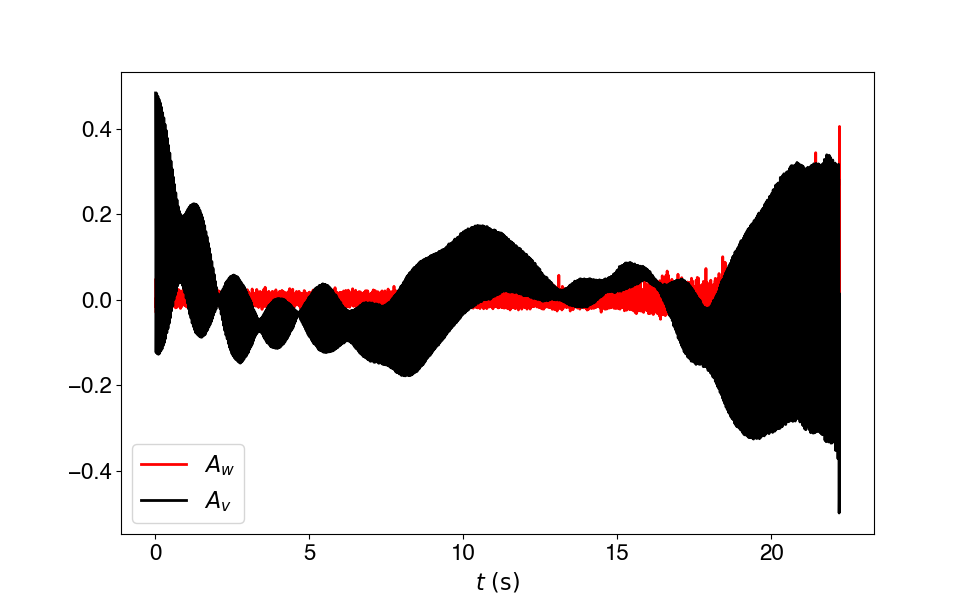

In [17]:
plt.figure(3,figsize=(6*ct.golden_ratio,6))
plt.xlabel(r'$t~\mathrm{(s)}$')
plt.plot(t[2:],Awt[2:],c ='r', lw=2)
plt.plot(t[2:],Avt[2:], c='k', lw =2)
plt.legend([r'$A_w$', r'$A_v$'])

In [259]:
plt.close(3)

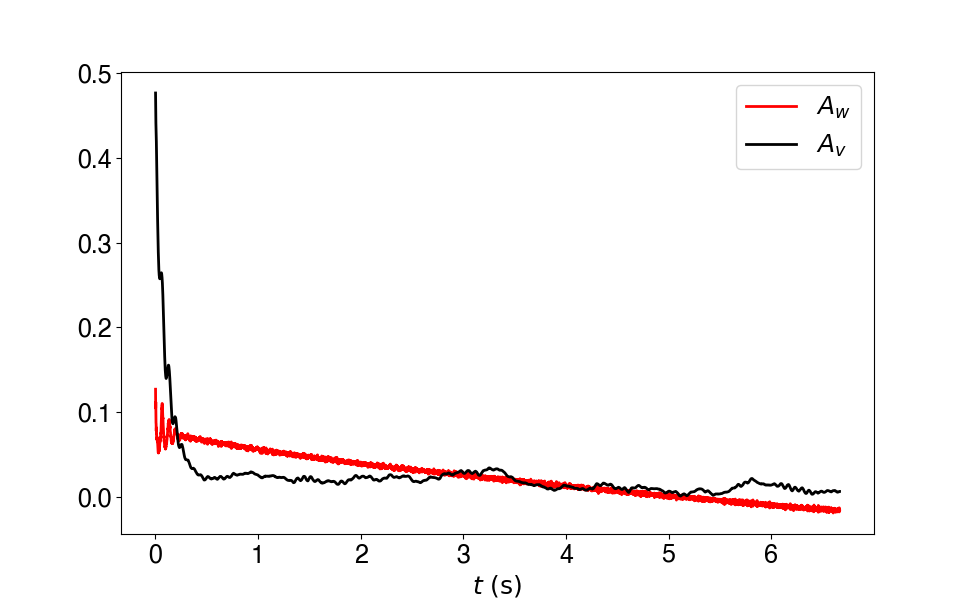

In [64]:
plt.figure(4,figsize=(6*ct.golden_ratio,6))
plt.xlabel(r'$t~\mathrm{(s)}$')
plt.plot(t[2:6000],Awt[2:6000],c ='r', lw=2)
plt.plot(t[2:6000],Avt[2:6000], c='k', lw =2)
plt.legend([r'$A_w$', r'$A_v$'])


In [63]:
plt.close(4)

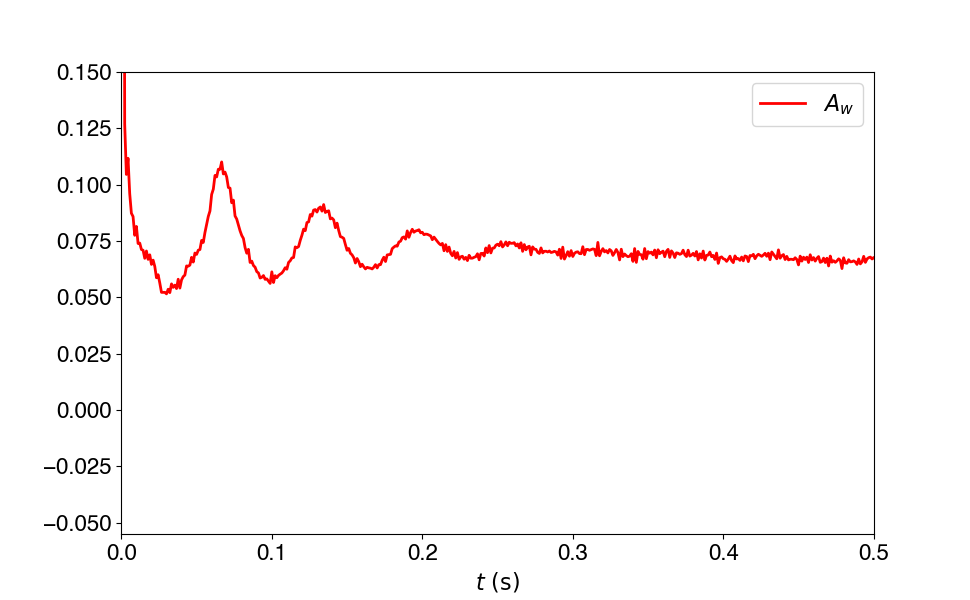

In [69]:
plt.figure(5,figsize=(6*ct.golden_ratio,6))
plt.xlabel(r'$t~\mathrm{(s)}$')
plt.ylim(-0.055,0.15)
plt.xlim(0,0.5)
#plt.xscale('log')
Awt[0]=1
Awt[1]=0.5
plt.plot(t[0:],Awt[0:],c ='r', lw=2)
Avt[0]=1
Avt[1]=0.5
#plt.plot(t[2:],Avt[2:], c='k', lw =2)
plt.legend([r'$A_w$', r'$A_v$'])

In [68]:
plt.close(5)

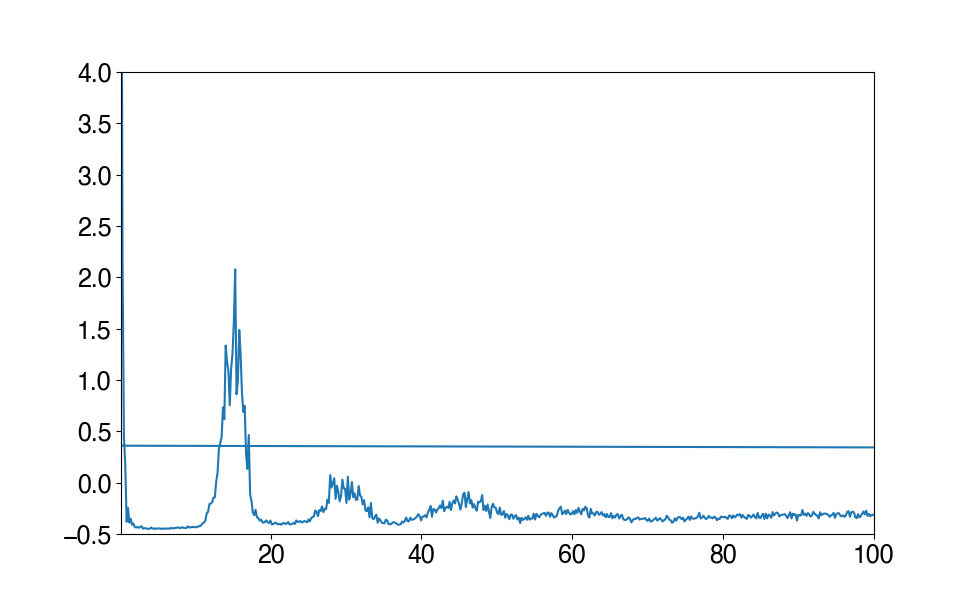

In [80]:
plt.figure(6, figsize=(6*ct.golden_ratio, 6))
plt.xlim(0.2,100)
plt.ylim(-0.5, 4)
plt.plot( fftfreq(5000,d=1/info.fps[0]), np.real(fft(Awt[:5000])) )

In [79]:
plt.close(6)

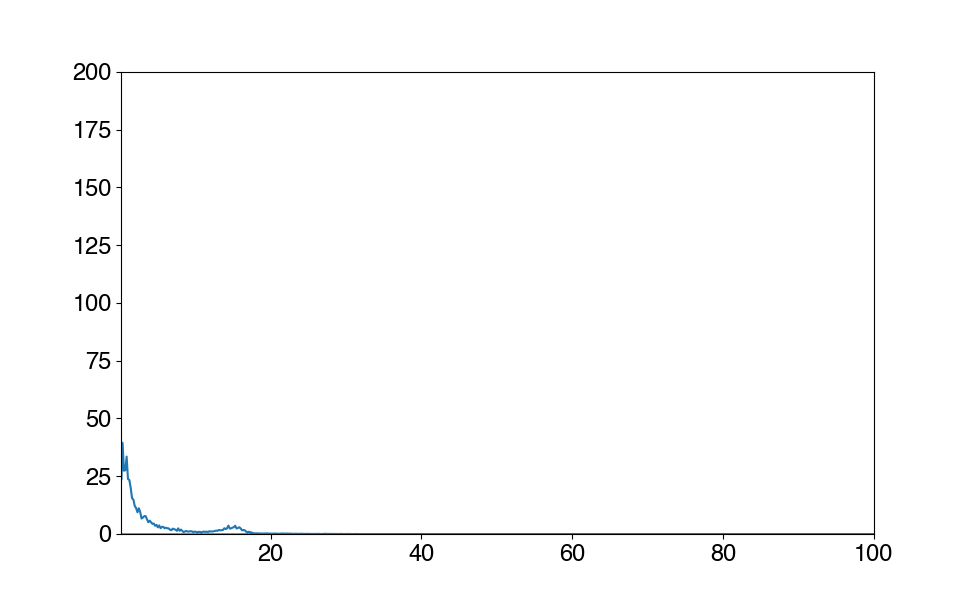

In [30]:
plt.figure(7, figsize=(6*ct.golden_ratio, 6))
plt.xlim(0.2,100)
plt.ylim(-0.1, 200)
plt.plot( fftfreq(5000,d=1/info.fps[0]), np.real(fft(Avt[:5000])) )

In [29]:
plt.close(7)

## Lists of critical frequencies $\omega_c$ for series $N=\{3, 10, 25, 45, 55\}$ 

In [18]:
# N = 03
Aw_w_03 = np.array( [ [1.821, 2.70], [8.761, 8.48], [13.165, 13.32], [16.890, 16.57], [20.702, 20.35], [25.566, 25.60], [25.293, 25.37] ] )
Av_w_03 = np.array( [ [1.821, 2.70], [8.761, 8.45], [13.165, 13.32], [16.890, 16.57], [20.702, 20.33], [25.566, 25.56], [25.293, 25.96 ] ] )
# N = 10
Aw_w_10 = np.array( [ [3.373, 6.11], [14.689 , 16.04], [16.071, 16.38], [19.507, 20.69], [20.337, 20.69], [24.946, 25.56], [25.573, 26.09] ] )
Av_w_10 = np.array( [ [3.373, 5.4], [14.689,  16.01], [16.071, 16.56], [19.507, 19.61], [20.337, 20.68], [24.946, 25.92 ], [25.573, 26.99] ] )
# N = 25
Aw_w_25 = np.array( [ [2.43, 6.841], [8.111, 12.25], [15.397, 15.12], [16.618, 16.76], [20.355, 20.16], [20.98, 21.08], [22.564, 22.20] ] )
Av_w_25 = np.array( [ [2.43, 6.842],  [8.111, 12.05], [15.397, 15.65], [16.618, 17.10], [20.355, 20.17], [20.98, 21.23 ], [22.564, 23.57] ] )
# N = 45
Aw_w_45 = np.array( [ [6.190, 10.26], [12.936, 13.51], [14.598, 15.29], [16.91, 17.10] ] )
Av_w_45 = np.array( [ [6.190, 10.28], [12.936, 13.50], [14.598, 15.31], [16.91, 17.29] ] )
# N = 55
Aw_w_55 = np.array( [ [8.079, 10.80], [8.34, 13.50], [9.885, 14.74], [10.10, 14.039], [13.629, 14.57] ] )
Av_w_55 = np.array( [ [8.079, 10.80], [8.34, 13.50], [9.885, 10.81], [10.10, 13.01 ], [13.629, 14.76] ] )


## FIGURE 1 main panel (preliminar) plot

['#f7fbff', '#d0e1f2', '#94c4df', '#4a98c9', '#1764ab', '#08306b']


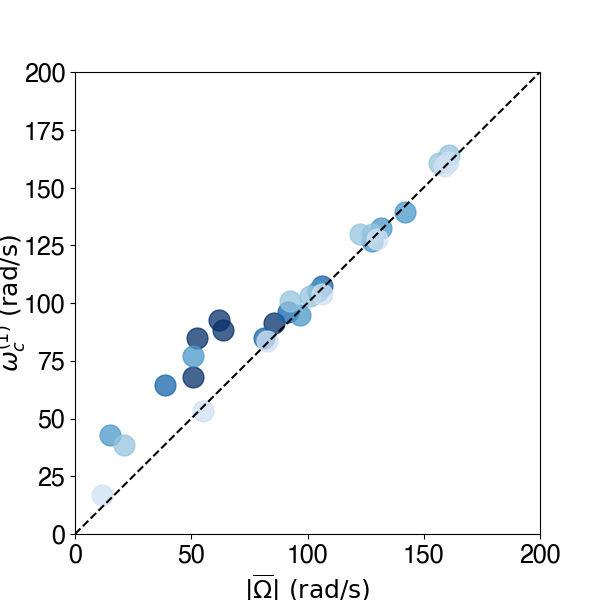

In [51]:
plt.figure(9, figsize =(6, 6))

plt.xlabel( r'$|\overline{\Omega}|~\mathrm{(rad/s)}$' )
plt.ylabel( r'$\omega_c^{(1)}~\mathrm{(rad/s)}$', labelpad=-4)

plt.ylim(0,200)
plt.xlim(0,200)
max0 = 200

color1=mcp.gen_color(cmap="Blues",n=6)
print(color1)
plt.plot(Aw_w_55.T[0]*2*np.pi, Aw_w_55.T[1] * 2*np.pi, '.', c=color1[-1], ms=30, alpha=0.75 )
#plt.plot(Av_w_55.T[0]*2*np.pi, Av_w_55.T[1] * 2*np.pi, '.', c='b', ms=30, alpha=0.8, fillstyle='none' )

plt.plot(Aw_w_45.T[0]*2*np.pi, Aw_w_45.T[1] * 2*np.pi, '.', c=color1[-2], ms=30, alpha=0.75)
#plt.plot(Av_w_45.T[0]*2*np.pi, Av_w_45.T[1] * 2*np.pi, '.', c='b', ms=30, alpha=0.6, fillstyle='none' )

plt.plot(Aw_w_25.T[0]*2*np.pi, Aw_w_25.T[1] * 2*np.pi, '.', c=color1[-3], ms=30, alpha=0.75 )
#plt.plot(Av_w_25.T[0]*2*np.pi, Av_w_25.T[1] * 2*np.pi, '.', c='b', ms=30, alpha=0.4, fillstyle='none' )

plt.plot(Aw_w_10.T[0]*2*np.pi, Aw_w_10.T[1] * 2*np.pi, '.', c=color1[-4], ms=30, alpha=0.75 )
#plt.plot(Av_w_25.T[0]*2*np.pi, Av_w_25.T[1] * 2*np.pi, '.', c='b', ms=30, alpha=0.4, fillstyle='none' )

plt.plot(Aw_w_03.T[0]*2*np.pi, Aw_w_03.T[1] * 2*np.pi, '.', c=color1[-5], ms=30, alpha=0.75 )
#plt.plot(Av_w_25.T[0]*2*np.pi, Av_w_25.T[1] * 2*np.pi, '.', c='b', ms=30, alpha=0.4, fillstyle='none' )

plt.plot(np.linspace(0,1.2*max0),np.linspace(0,1.2*max0), '--', c='k' )


In [49]:
plt.close(9)

In [70]:
Awt45 = np.copy(Awt)
Avt45 = np.copy(Avt)
w45= np.copy(fftfreq(5000,d=1/info.fps[0]))
FFT45= np.copy(np.real(fft(Awt[:5000])))

In [57]:
Awt03 = np.copy(Awt)
Avt03 = np.copy(Avt)
w03= np.copy(fftfreq(5000,d=1/info.fps[0]))
FFT03= np.copy(np.real(fft(Awt[:5000])))

## FIGURE 1

['#fde725', '#5cc863', '#21908d', '#3b518b', '#440154']


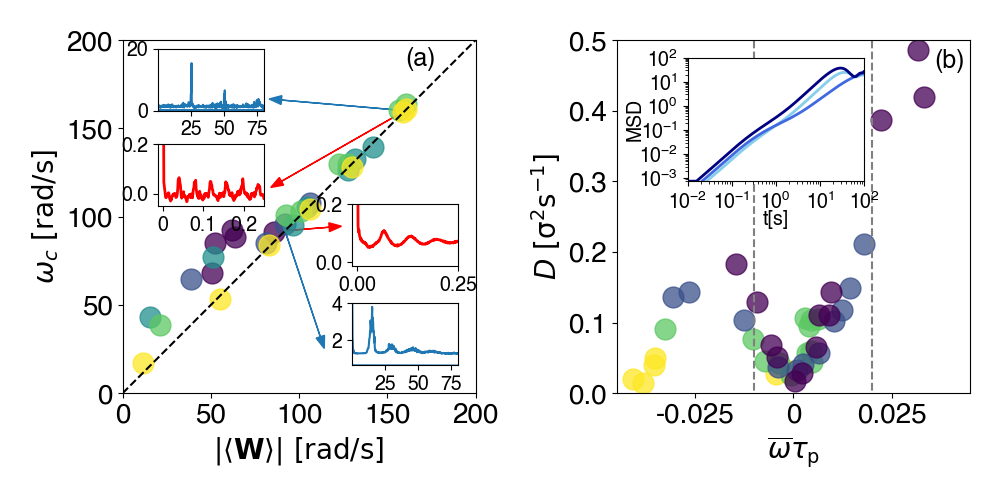

In [96]:
# Create Blank Figure
fig = plt.figure(10, figsize=(10, 5))
mf = 14

# Matplotlib default color palette
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
# Alternate Symbol color palette
omega_colors=mcp.gen_color(cmap="viridis_r",n=5)
print(omega_colors)

# Create 2x2 Grid
gs = fig.add_gridspec(nrows=1, ncols=2)

# Create Two main Axes Objects
# FIG 1
# MAIN PANEL A
ax1 = fig.add_subplot(gs[0, 0]) 
# MAIN PANEL B
ax2 = fig.add_subplot(gs[0, 1]) 
# FIG 1A INSETS definitions
ax1_ins_FFT03 = ax1.inset_axes([0.10, 0.80, 0.3, 0.175])
ax1_ins_Awt03 = ax1.inset_axes([0.10, 0.53, 0.3, 0.175])
ax1_ins_FFT45 = ax1.inset_axes([0.65, 0.08, 0.3, 0.175])
ax1_ins_Awt45 = ax1.inset_axes([0.65, 0.36, 0.3, 0.175])
# FIG 1B INSET definition
ax2_ins = ax2.inset_axes([0.2, 0.6, 0.5, 0.35])

###########################################################
# FIG 1A
###########################################################

###########
# MAIN AXIS
###########

# axis properties
ax1.text(160,185, '(a)', fontsize=18)
ax1.set_xlabel( r'$|\langle{\mathbf{W}}\rangle|~\mathrm{[rad/s]}$' )
ax1.set_ylabel( r'$\omega_c~\mathrm{[rad/s]}$')
ax1.set_ylim(0,200)
ax1.set_xlim(0,200)
max0 = 200

ax1.plot(Aw_w_55.T[0]*2*np.pi, Aw_w_55.T[1] * 2*np.pi, '.', c=omega_colors[-1], ms=30, alpha=0.75 )
#plt.plot(Av_w_55.T[0]*2*np.pi, Av_w_55.T[1] * 2*np.pi, '.', c='b', ms=30, alpha=0.8, fillstyle='none' )

ax1.plot(Aw_w_45.T[0]*2*np.pi, Aw_w_45.T[1] * 2*np.pi, '.', c=omega_colors[-2], ms=30, alpha=0.75)
#plt.plot(Av_w_45.T[0]*2*np.pi, Av_w_45.T[1] * 2*np.pi, '.', c='b', ms=30, alpha=0.6, fillstyle='none' )

ax1.plot(Aw_w_25.T[0]*2*np.pi, Aw_w_25.T[1] * 2*np.pi, '.', c=omega_colors[-3], ms=30, alpha=0.75 )
#plt.plot(Av_w_25.T[0]*2*np.pi, Av_w_25.T[1] * 2*np.pi, '.', c='b', ms=30, alpha=0.4, fillstyle='none' )

ax1.plot(Aw_w_10.T[0]*2*np.pi, Aw_w_10.T[1] * 2*np.pi, '.', c=omega_colors[-4], ms=30, alpha=0.75 )
#plt.plot(Av_w_25.T[0]*2*np.pi, Av_w_25.T[1] * 2*np.pi, '.', c='b', ms=30, alpha=0.4, fillstyle='none' )

ax1.plot(Aw_w_03.T[0]*2*np.pi, Aw_w_03.T[1] * 2*np.pi, '.', c=omega_colors[-5], ms=30, alpha=0.75 )
#plt.plot(Av_w_25.T[0]*2*np.pi, Av_w_25.T[1] * 2*np.pi, '.', c='b', ms=30, alpha=0.4, fillstyle='none' )

ax1.arrow(160, 160, -70, -40, head_width=5, head_length=7, fc='r', ec='r')
ax1.arrow(160, 160, -70, 6, head_width=5, head_length=7,fc=colors[0], ec=colors[0])

ax1.arrow(92, 92, 20, -60, head_width=5, head_length=7, fc=colors[0], ec=colors[0])
ax1.arrow(92, 92, 25, 2, head_width=5, head_length=7,fc='r', ec='r')

ax1.plot(np.linspace(0,1.2*max0),np.linspace(0,1.2*max0), '--', c='k' )


###############
# N = 3 INSETS
###############
# ID: 04517f89e5599ab3749b603f3b87d69c

# FFT
ax1_ins_FFT03.tick_params( labelsize=mf)
ax1_ins_FFT03.set_xlim(0.2,80)
ax1_ins_FFT03.set_ylim(0, 20)
ax1_ins_FFT03.plot( w03, FFT03 )
# AW
ax1_ins_Awt03.tick_params( labelsize=mf) 
ax1_ins_Awt03.set_xlim(-0.0125,0.25)
ax1_ins_Awt03.set_ylim(-0.05,0.2)
w_xticks = [0., 0.1, 0.2]
w_xlabels = ['0', '0.1', '0.2']
ax1_ins_Awt03.set_xticks(w_xticks, w_xlabels)
ax1_ins_Awt03.plot(t[0:600],Awt03[0:600],c ='r', lw=2)

###############
# N = 45 INSETS. 
###############
# ID: 712d5be2fce52eade6c5564a1f80368f

# FFT
ax1_ins_FFT45.tick_params( labelsize=mf) 
#ax1_ins_FFT45.set_xlabel(r'$f~\mathrm{(Hz)}$', fontsize=mf, labelpad=-1)
#ax1_ins_FFT45.set_ylabel(r'$\mathrm{FFT}$', fontsize=mf, labelpad=-1)
ax1_ins_FFT45.set_xlim(0.2,80)
ax1_ins_FFT45.set_ylim(0.65, 4)
ax1_ins_FFT45.plot( w45, FFT45 )

# AW
ax1_ins_Awt45.tick_params( labelsize=mf) 
#ax1_ins_Awt45.set_xlabel(r'$t~\mathrm{(s)}$', fontsize=mf, labelpad=-1)
#ax1_ins_Awt45.set_ylabel(r'$A_W~\mathrm{(t)}$', fontsize=mf, labelpad=-4)
ax1_ins_Awt45.set_xlim(-0.0125,0.25)
ax1_ins_Awt45.set_ylim(-0.0125,0.2)
ax1_ins_Awt45.plot(t[0:600],Awt45[0:600],c ='r', lw=2)


###########################################################
# FIG 1B
###########################################################

tablaD = pd.read_csv('/home/fvega/Datos/blades/prl_comment/diff_coef.dat', sep='\s+')
tabla_msd = pd.read_csv('/home/fvega/Datos/blades/prl_comment/msd.dat', sep ='\s+')


###########
# MAIN AXIS
###########
ax2.text(0.036,0.46, '(b)', fontsize=18)
ax2.set_xlabel(r'$\overline{\omega} \tau_\mathrm{p}$')
ax2.set_ylabel(r'$D~\mathrm{[\sigma^2s^{-1}]}$')
w_xticks = [-0.025, 0, 0.025]
w_xlabels = ['-0.025', '0', '0.025']
ax2.set_xticks(w_xticks, w_xlabels)
ax2.set_xlim(-0.045,0.045)
ax2.set_ylim(0,0.5)
N0 = 3
ax2.plot(tablaD[tablaD.N==N0].omega.values/np.sqrt(tablaD[tablaD.N==N0].Trf.values), tablaD[tablaD.N==N0].D.values,'.', ms=30, c=omega_colors[-5], alpha=0.75)
N0 = 10
ax2.plot(tablaD[tablaD.N==N0].omega.values/np.sqrt(tablaD[tablaD.N==N0].Trf.values), tablaD[tablaD.N==N0].D.values,'.', ms=30, c=omega_colors[-4], alpha=0.75 )
N0 = 25
ax2.plot(tablaD[tablaD.N==N0].omega.values/np.sqrt(tablaD[tablaD.N==N0].Trf.values), tablaD[tablaD.N==N0].D.values,'.', ms=30, c=omega_colors[-2], alpha=0.75)
N0 = 45
ax2.plot(tablaD[tablaD.N==N0].omega.values/np.sqrt(tablaD[tablaD.N==N0].Trf.values), tablaD[tablaD.N==N0].D.values,'.', ms=30, c=omega_colors[-1], alpha=0.75)

ax2.plot(-0.01*np.ones(50),np.linspace(-1,1.2*0.5), '--', c='grey' )
ax2.plot(0.02*np.ones(50),np.linspace(-1,1.2*0.5), '--', c='grey' )

###############
# FIG 1B INSET
###############
# N=55
ax2_ins.tick_params( labelsize=mf)
ax2_ins.set_xlabel('t[s]', fontsize=mf, labelpad=-2)
ax2_ins.set_ylabel('MSD', fontsize=mf, labelpad=-4)
ax2_ins.set_yscale('log')
ax2_ins.set_xscale('log')
ax2_ins.set_ylim(0.00075, 100)
ax2_ins.set_xlim(0.01, 100)
ax2_ins.xaxis.set_major_locator(tck.LogLocator(numticks=999))
ax2_ins.xaxis.set_minor_locator(tck.LogLocator(numticks=999, subs="auto"))
ax2_ins.yaxis.set_major_locator(tck.LogLocator(numticks=999))
ax2_ins.yaxis.set_minor_locator(tck.LogLocator(numticks=999, subs="auto"))
#ax2_ins.grid(which='major', linewidth=0.5)
#ax2_ins.grid(which='minor', linewidth=0.05)
ax2_ins.plot(tabla_msd.t.values, tabla_msd['c+'].values, c='skyblue', lw=2)
ax2_ins.plot(tabla_msd.t.values, tabla_msd['c0'].values, c='royalblue', lw =2)
ax2_ins.plot(tabla_msd.t.values, tabla_msd['c-'].values, c='navy',lw=2)

plt.tight_layout()

In [75]:
plt.close(10)

In [97]:
plt.savefig('fig1_v2.pdf', bbox_inches='tight')

## FIGURE 1 SUPPLEMENTARY MATERIAL

['#fde725', '#5cc863', '#21908d', '#3b518b', '#440154']
['#fde725', '#21908d', '#440154']


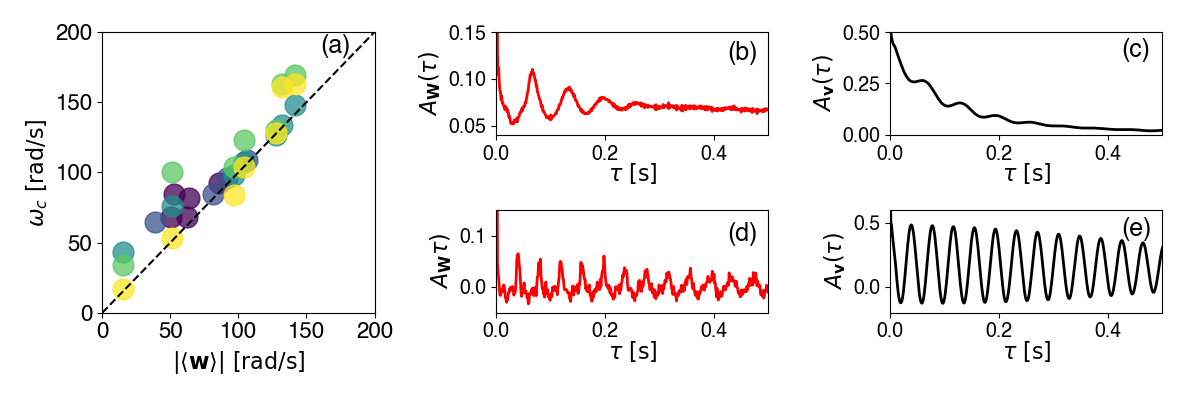

In [93]:
#msd = pd.read_csv('/home/fvega/Datos/blades/prl_comment/msd.dat', sep='\t')

# Create Blank Figure
fig = plt.figure(11, figsize=(12, 4))
mf = 14

# Matplotlib default color palette
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
# Alternate Symbol color palette
omega_colors=mcp.gen_color(cmap="viridis_r",n=5)
print(omega_colors)
msd_colors=mcp.gen_color(cmap="viridis_r",n=3)
print(msd_colors)

# Create 2x2 Grid
gs = fig.add_gridspec(nrows=2, ncols=6)

# Create Two main Axes Objects
# FIG 1
# Critical frequencies of Av: MAIN PANEL (left side)
ax1 = fig.add_subplot(gs[0:2, 0:2]) 
# Autocorrelations: 4 PANELS (right side)
ax21 = fig.add_subplot(gs[0,2:4])
ax21.tick_params( labelsize=mf)
ax22 = fig.add_subplot(gs[0,4:]) 
ax22.tick_params( labelsize=mf)
ax23 = fig.add_subplot(gs[1,2:4]) 
ax23.tick_params( labelsize=mf)
ax24 = fig.add_subplot(gs[1,4:]) 
ax24.tick_params( labelsize=mf)


# axis properties
ax1.text(160,185, '(a)', fontsize=18)
ax1.set_xlabel( r'$|\langle\mathbf{w}\rangle|~\mathrm{[rad/s]}$' )
ax1.set_ylabel( r'$\omega_c~\mathrm{[rad/s]}$')
ax1.set_ylim(0,200)
ax1.set_xlim(0,200)
max0 = 200

ax1.plot(Av_w_55.T[0]*2*np.pi, Av_w_55.T[1] * 2*np.pi, '.', c=omega_colors[-1], ms=30, alpha=0.75  )
ax1.plot(Av_w_45.T[0]*2*np.pi, Av_w_45.T[1] * 2*np.pi, '.', c=omega_colors[-2], ms=30, alpha=0.75  )
ax1.plot(Av_w_25.T[0]*2*np.pi, Av_w_25.T[1] * 2*np.pi, '.', c=omega_colors[-3], ms=30, alpha=0.75  )
ax1.plot(Av_w_25.T[0]*2*np.pi, Av_w_10.T[1] * 2*np.pi, '.', c=omega_colors[-4], ms=30, alpha=0.75  )
ax1.plot(Av_w_25.T[0]*2*np.pi, Av_w_03.T[1] * 2*np.pi, '.', c=omega_colors[-5], ms=30, alpha=0.75  )

ax1.plot(np.linspace(0,1.2*max0),np.linspace(0,1.2*max0), '--', c='k' )

ax21.text(0.425,0.12, '(b)', fontsize=18)
ax21.set_xlabel(r'$\tau~\mathrm{ [s]}$', labelpad=-2)
ax21.set_ylabel(r'$A_\mathbf{W}(\tau)$')
ax21.set_ylim(0.04,0.15)
ax21.set_xlim(0,0.5)
ax21.plot(t[0:],Awt45[0:],c ='r', lw=2)

ax22.text(0.425,0.38, '(c)', fontsize=18)
ax22.set_xlabel(r'$\tau~\mathrm{[s]}$', labelpad=-2)
ax22.set_ylabel(r'$A_\mathbf{v}(\tau)$')
ax22.set_ylim(0.0,0.5)
ax22.set_xlim(0,0.5)
ax22.plot(t[0:],Avt45[0:],c ='k', lw=2)

ax23.text(0.425,0.09, '(d)', fontsize=18)
ax23.set_xlabel(r'$\tau~\mathrm{[s]}$', labelpad=-2)
ax23.set_ylabel(r'$A_\mathbf{W}\tau)$')
ax23.set_ylim(-0.05,0.15)
ax23.set_xlim(0,0.5)
ax23.plot(t[0:],Awt03[0:],c ='r', lw=2)

ax24.text(0.425,0.40, '(e)', fontsize=18)
ax24.set_xlabel(r'$\tau~\mathrm{[s]}$', labelpad=-2)
ax24.set_ylabel(r'$A_\mathbf{v}(\tau)$')
ax24.set_ylim(-0.2,0.6)
ax24.set_xlim(0,0.5)
ax24.plot(t[0:],Avt03[0:],c ='k', lw=2)

plt.tight_layout()

In [92]:
plt.close(11)

In [94]:
plt.savefig('/home/fvega/Documentos/Publicaciones/chiral_comment/fig1s.pdf')